In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Data Processing
## Todo List
1. Calculate running totals and average wins/loses
2. Generate Plots
3. Assign skill scores
4. Create betting metrics/odds
5. Easy data entry mode

In [14]:
df_data = pd.read_csv("data.csv")
guests = ['oscar','nick','drew','ruohan','brandon','lixin','alice']
big3 = ['connor','helio','sam']
#Add a guest column
df_data['guest']= df_data[guests].sum(axis=1, min_count=1)
players = big3+guests+['guest']
df = df_data[players].fillna(0).cumsum()

# Mask non-played games to prevent graphing
df = df.mask(df_data[players].isna())

# Add a starting row at index -1 with all zeros to ensure graphs start at 0
start_row = pd.Series(0, index=players, name=-1)
df = pd.concat([pd.DataFrame([start_row]), df]).sort_index()

# For all players, ensure there's a connection from 0 to their first game
for p in players:
    first_idx = df_data[p].first_valid_index()
    if first_idx is not None and first_idx > 0:
        df.loc[first_idx - 1, p] = 0

#Convert to Dollars
df = df/100
#df.to_csv("results.csv", index = False)

## Some Basic Plots
We start with the net profit loss chart. 

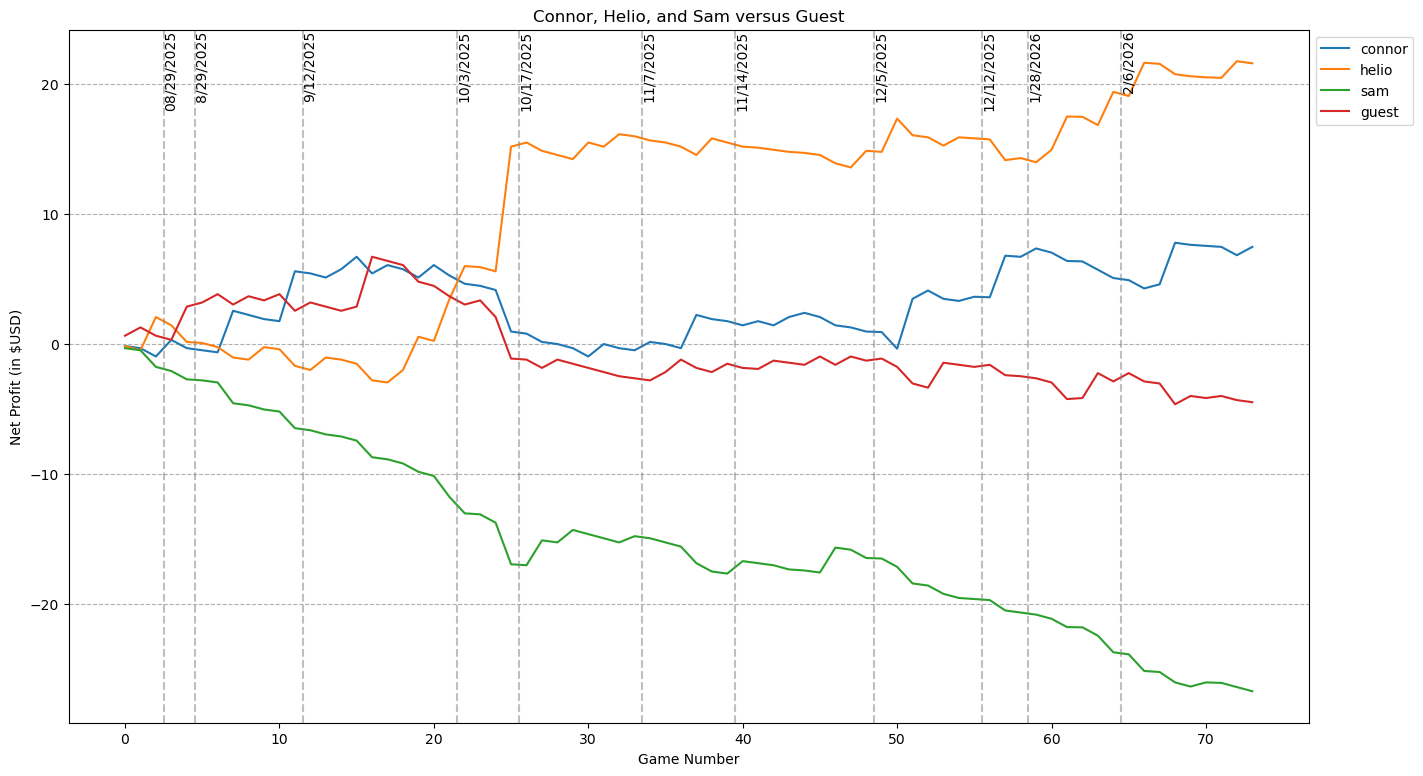

In [15]:
ax1 = df[big3+['guest']].plot(figsize=(16, 9))
ax1.set_title('Connor, Helio, and Sam versus Guest')

# Vertical bars for days with labels
y_min, y_max = ax1.get_ylim()
date_changes = df_data.index[df_data['date'].ne(df_data['date'].shift())].tolist()
for i in date_changes:
    if i == 0:
        plt.text(-1, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)
    else:
        plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.5)
        plt.text(i-0.5, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)

# Horizontal lines
plt.grid(axis='y', linestyle='--')

plt.xlabel("Game Number")
plt.ylabel("Net Profit (in $USD)")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit.png", bbox_inches='tight')


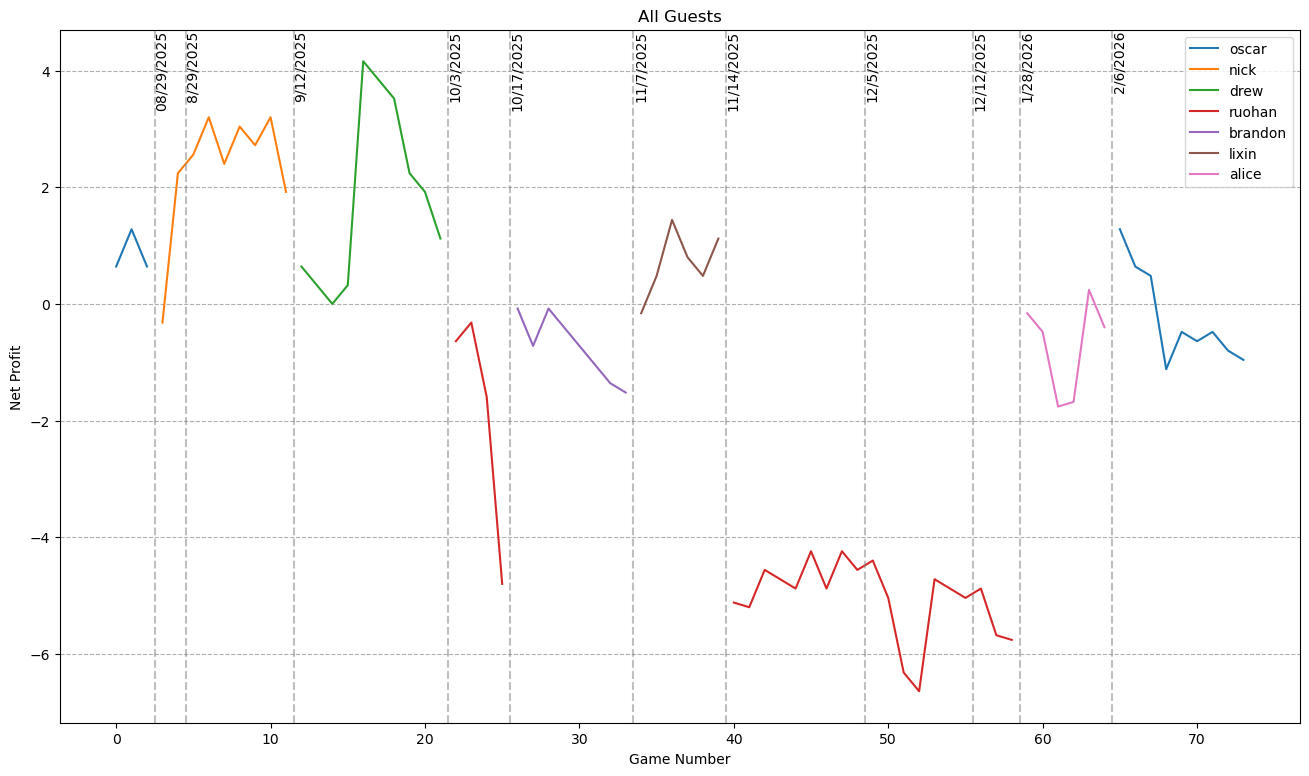

In [16]:

ax2 = df[guests].plot(figsize=(16, 9))
ax2.set_title('All Guests')

# Vertical bars for days with labels
y_min, y_max = ax2.get_ylim()
date_changes = df_data.index[df_data['date'].ne(df_data['date'].shift())].tolist()
for i in date_changes:
    if i == 0:
        plt.text(-1, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)
    else:
        plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.5)
        plt.text(i-0.5, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)

# Horizontal lines
plt.grid(axis='y', linestyle='--')

plt.xlabel("Game Number")
plt.ylabel("Net Profit")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit_guests.png", bbox_inches="tight")


## Autocorrelation Plots
An autocorrelogram shows that there appears to be a self correlation for low amounts of lag. The current theory for this is that this may be picking up the winning advantage of being dealer, and if someone wins while dealer they remain dealer hence giving a *hot hands* effect. 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

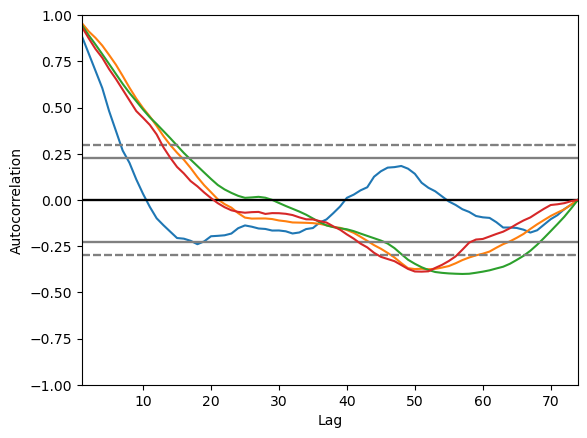

In [17]:
pd.plotting.autocorrelation_plot(df['connor'])
pd.plotting.autocorrelation_plot(df['helio'])
pd.plotting.autocorrelation_plot(df['sam'])
pd.plotting.autocorrelation_plot(df['guest'])

## Trend decomposition
We suspect that a players performance over time is an additive function of some linear trend with noise. We can verify this by taking a trend decomposition of net profit/loss. 

In [18]:
#Convert to Readme